### Analysis software development 

Goal: establish smooth reading of the binary DAQ datafiles

In [1]:
import sys
sys.path.insert(0,'python/')
import struct
import matplotlib.pyplot as plt
from scipy.stats import norm

import numpy as np
# import data handling class
from DT5550 import *

Open a datafile and read the data

In [2]:
#
# open the datfile / data directory
#
    
io = DT5550(indir='C:/data/20220110_165917/')
#io = DT5550(file='C:/data/20220110_165917/data_20220110_165917_24.raw')

#
# loop over all the events
#
dt_max = 10

Etot = []
Etot_sel = []
nhit_tag = np.zeros(8)
nhit_untag = np.zeros(8)
ee = []

r = [[], [], [], [], [], [], [], []]
#for i in range(8):
#    r.append([])

nmax = 2
nf = 0
idet_old = 0

for file in io.filenames:
    io.open_data(file)
    nf = nf + 1
    if nf>nmax:
        break
    while io.read_event() == 0:
        #
        # data: io.Q[0:ndet-1] -> energy
        #       io.ph[0:ndet-1] -> peak height
        #       io.t[0:ndet-1] -> time without timewalk correction
        #       io.tc[0:ndet-1] -> time with timewalk correction
        #       io.valid[0:ndet-1] -> valid bit = 1 for valid data
        
        nh = io.valid.sum()
        
        # events with on hit
        if nh == 1:
            for idet in range(8):
                if io.valid[idet]:
                    r[idet].append(io.R[idet])
                
                if io.valid[idet] and io.Q[idet]>1250 and io.Q[idet]<1450:
                    nhit_untag[idet] += 1
                    #idet_old = idet
                    
        # events with two hits
        if nh == 2:
            id_sel = []
            for idet in range(8):
                if io.valid[idet]:
                    id_sel.append(idet)
                    
            id0 = id_sel[0]
            id1 = id_sel[1]
            #  the total measured energy
            Etot.append(io.Q.sum()) 
            
            delta_t = io.tc[id1] - io.tc[id0]
            if id0 == 0:
                if abs(delta_t) < dt_max:
                    Esum = io.Q[id0] + io.Q[id1]
                    Etot_sel.append(Esum)
                    if io.Q[id0]>1100 and io.Q[id0]<1250: # tag
                        ee.append(io.Q[id1])
                        if io.Q[id1]>1250 and io.Q[id1]<1450:
                            nhit_tag[id1] += 1
                            #nhit_untag[idet_old] += 1
                

print('Processing done')

Etot = np.array(Etot,dtype=object)
Etot_sel = np.array(Etot_sel,dtype=object)
ee = np.array(ee)
r = np.array(r, dtype=object)

DT5550:: Data recorded with config:  C:/data/20220110_165917\config_20220110_165917.json
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_0.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_1.raw
DT5550:: Open data file: C:/data/20220110_165917\data_20220110_165917_10.raw
Processing done


A few basic plots: integrated charge and time

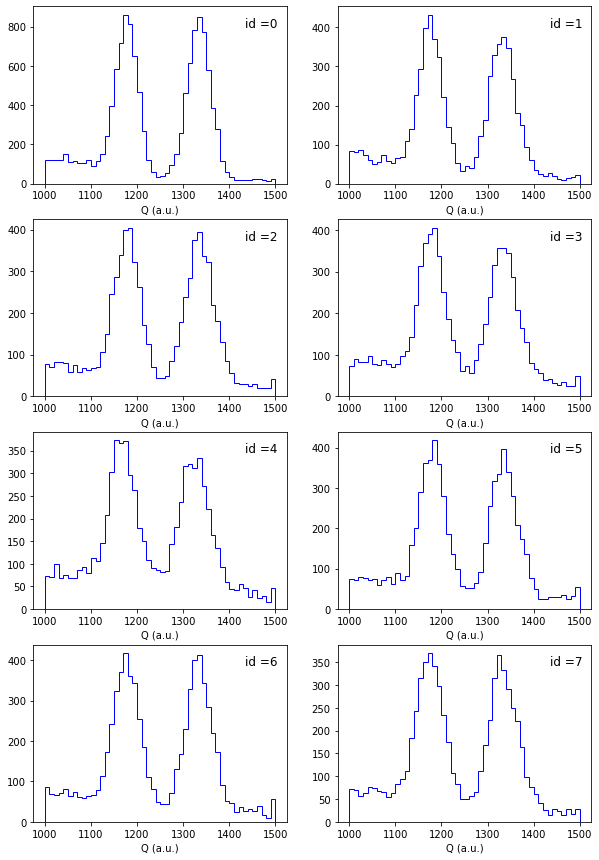

In [3]:
io.plot_all(type="charge",bins=50,logy=False, range=(1000,1500))

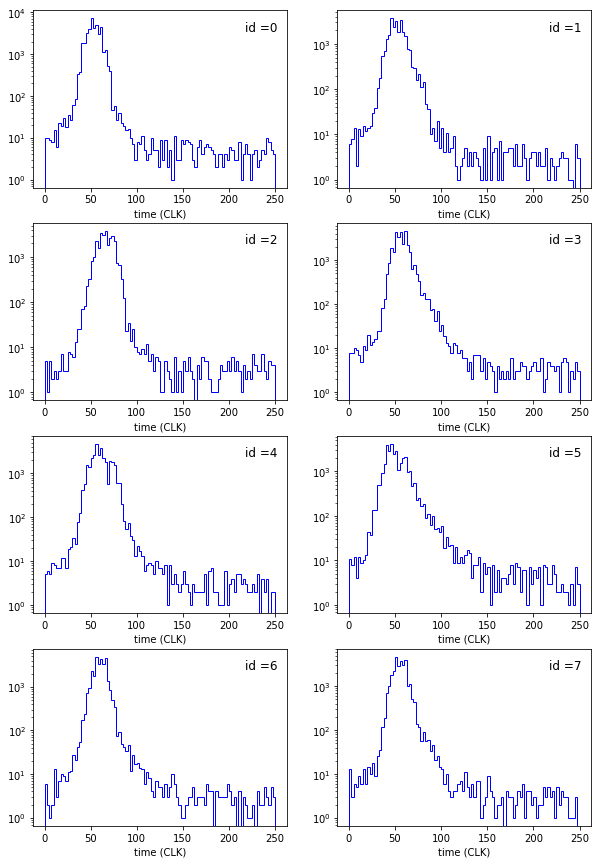

In [4]:
io.plot_all(type="time",range=(0,250),bins=100,logy=True)

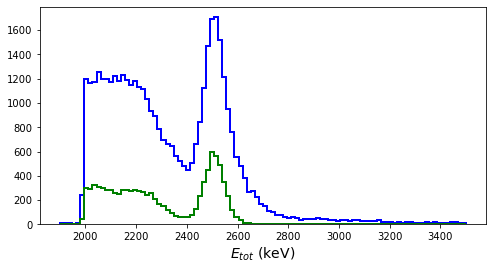

In [5]:
plt.figure(figsize=(8,4))

plot_range=(1900,3500)
plt.hist(Etot, bins=100, range=plot_range, histtype='step', color='blue', linewidth=2)
plt.hist(Etot_sel, bins=100, range=plot_range, histtype='step', color='green', linewidth=2)

plt.xlabel('$E_{tot}$ (keV)', fontsize=14)
plt.yscale('linear')

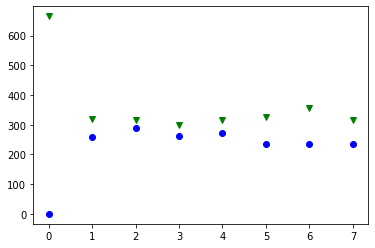

In [6]:
plt.plot(nhit_tag,'o',color='blue')
plt.plot(nhit_untag,'v', color='green')
#plt.ylim([2000,4000])

(0.08, 0.12)

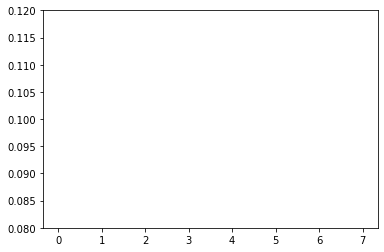

In [7]:
plt.plot(nhit_tag/nhit_untag,'o',color='blue')
plt.ylim([0.08,0.12])

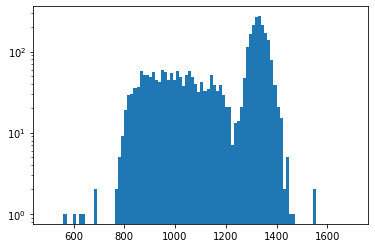

In [8]:
h = plt.hist(ee,bins=100,range=(500,1700))
plt.yscale('log')

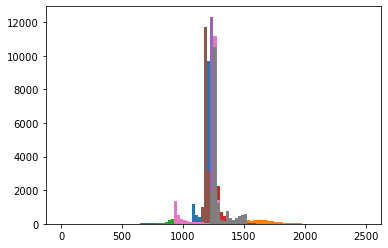

In [9]:
for i in range(8):
    h = plt.hist(r[i],bins=100,range=(0,2500))
plt.yscale('linear')

In [10]:
a = np.hstack(r)

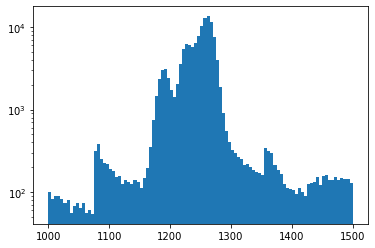

In [11]:
h = plt.hist(a,bins=100,range=(1000,1500))
plt.yscale('log')

In [12]:
np.shape(a)

(143362,)